# Kaggle Titanic: Applying Decision Tree to predict Fatalities and Survivors

In this program we will process the data, create Decision Tree, Perform Cross Validation and finally using Grid Search will obtain best depth for tree and obtain accuracies as well compare it with Decision Tree accuracy.

## Importing required Libraries and Loading data

In [105]:
import os
import subprocess
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import  cross_val_score
from time import time
from operator import itemgetter

%matplotlib inline

In [106]:
data = pd.read_csv('Titanic.csv',header='infer',parse_dates=True, infer_datetime_format=True);

In [107]:
data.head(3)

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Dropping data where age is not specified as it will not be helpful

In [108]:
data.dropna(axis=0, how='any')
data_filtered = data[~np.isnan(data['age'])]

In [109]:
data_filtered.describe()

,Unnamed: 0,survived,age,sibsp,parch,fare,body
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.00000,1045.000000,120.00000
mean,600.216061,0.408222,29.881135,0.502868,0.42065,36.686080,160.87500
std,364.657513,0.491740,14.413500,0.912167,0.83975,55.732534,98.10392
min,1.000000,0.000000,0.166700,0.000000,0.00000,0.000000,1.00000
25%,299.250000,0.000000,21.000000,0.000000,0.00000,8.050000,71.50000
50%,575.500000,0.000000,28.000000,0.000000,0.00000,15.750000,155.50000
75%,875.500000,1.000000,39.000000,1.000000,1.00000,35.500000,256.50000
max,1309.000000,1.000000,80.000000,8.000000,6.00000,512.329224,328.00000


In [110]:
data.describe()

,Unnamed: 0,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,655.000000,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,378.020061,0.486055,14.413500,1.041658,0.865560,51.758669,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,328.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,655.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,982.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,1309.000000,1.000000,80.000000,8.000000,9.000000,512.329224,328.000000


In [111]:
def sex_to_numeric(x):
    if x=='female':
        return 0
    if x=='male':
        return 1
    

## Converting Gender to boolean value 0 and 1 to make processing easy

In [112]:
data_filtered['sex'] = data_filtered['sex'].apply(sex_to_numeric)

/Users/khushalidave/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## This function converts string to integer for example: 1st to 1 which will make processing easy for attribute pclass which has values 1st , 2nd

In [113]:
def encode_target(df, target_column):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.

    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

In [114]:
df2, targets = encode_target(data_filtered, "pclass")

In [115]:
df2 = df2.drop(["pclass"],axis=1)

In [116]:
df2["pclass"] = df2["Target"]

In [117]:
df2.tail(10)

,Unnamed: 0,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,Target,pclass
1295,1296,0,"Windelov, Mr. Einar",1,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,Southampton,NaN,NaN,NaN,2,2
1296,1297,0,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,Southampton,NaN,131.0,NaN,2,2
1298,1299,0,"Wittevrongel, Mr. Camille",1,36.0,0,0,345771,9.5000,NaN,Southampton,NaN,NaN,NaN,2,2
1299,1300,0,"Yasbeck, Mr. Antoni",1,27.0,1,0,2659,14.4542,NaN,Cherbourg,C,NaN,NaN,2,2
1300,1301,1,"Yasbeck, Mrs. Antoni (Selini Al",0,15.0,1,0,2659,14.4542,NaN,Cherbourg,NaN,NaN,NaN,2,2
1301,1302,0,"Youseff, Mr. Gerious",1,45.5,0,0,2628,7.2250,NaN,Cherbourg,NaN,312.0,NaN,2,2
1304,1305,0,"Zabour, Miss. Hileni",0,14.5,1,0,2665,14.4542,NaN,Cherbourg,NaN,328.0,NaN,2,2
1306,1307,0,"Zakarian, Mr. Mapriededer",1,26.5,0,0,2656,7.2250,NaN,Cherbourg,NaN,304.0,NaN,2,2
1307,1308,0,"Zakarian, Mr. Ortin",1,27.0,0,0,2670,7.2250,NaN,Cherbourg,NaN,NaN,NaN,2,2
1308,1309,0,"Zimmerman, Mr. Leo",1,29.0,0,0,315082,7.8750,NaN,Southampton,NaN,NaN,NaN,2,2


In [118]:
data_filtered.count()

Unnamed: 0    1046
pclass        1046
survived      1046
name          1046
sex           1046
age           1046
sibsp         1046
parch         1046
ticket        1046
fare          1045
cabin          272
embarked      1044
boat           417
body           120
home.dest      685
dtype: int64

In [119]:
data_filtered.head(10)

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",0,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",1,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",0,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",1,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",0,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,6,1st,1,"Anderson, Mr. Harry",1,48.0000,0,0,19952,26.549999,E12,Southampton,3,NaN,"New York, NY"
6,7,1st,1,"Andrews, Miss. Kornelia Theodos",0,63.0000,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,8,1st,0,"Andrews, Mr. Thomas Jr",1,39.0000,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,9,1st,1,"Appleton, Mrs. Edward Dale (Cha",0,53.0000,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"
9,10,1st,0,"Artagaveytia, Mr. Ramon",1,71.0000,0,0,PC 17609,49.504200,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


## Selecting independent variables ‘pclass + sex + age + sibsp’ to predict

In [120]:
X = df2[['pclass','sex','age','sibsp']]

In [121]:
Y = df2['survived']

## Dividing the training and the testing data in 60-40 ratio

In [122]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.60)

In [123]:
X_train.head(10)

,pclass,sex,age,sibsp
515,1,1,3.0,1
1106,2,0,41.0,0
546,1,0,28.0,0
778,2,0,30.0,0
369,1,0,29.0,1
314,0,0,50.0,1
567,1,1,25.0,0
326,1,1,18.0,0
439,1,1,49.0,1
259,0,1,34.0,0


In [124]:
# A function that gives a visual representation of the decision tree

# def Decision_Tree_Image(decision_tree, feature_names, name="gem"):
    
#     # Export our decision tree to graphviz format
#     dot_file = export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    
#     # Call graphviz to make an image file from our decision tree
#     os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
#     # Return the .png image so we can see it
#     return Image(filename='images/' + name + '.png')




# A function to plot the data

def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) , max(data[v1]) ])
    plt.ylim([min(data[v2]) , max(data[v2]) ])

In [125]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

### Fittting a decision tree model using independent variables ‘pclass + sex + age + sibsp’ and dependent variable ‘survived’ and plotting the full decision tree generated

In [126]:
# Fitting model
decision_tree = DecisionTreeClassifier(criterion="entropy")



In [127]:
# Let's tell the model what is the data
decision_tree.fit(X_train, Y_train)





DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [128]:
visualize_tree(decision_tree, X.columns)

In [129]:
in_sample = pd.DataFrame(list(zip(decision_tree.predict(X_train), Y_train)), columns=['predicted', 'actual'])

## Calculating Accuracies for Fatalities and Survivors

In [130]:
in_sample_survivor = in_sample[in_sample.actual == 1]
total_survivor = in_sample_survivor.count().actual
print("total_survivor == %.3f" %total_survivor)

in_sample_survivor_success = in_sample_survivor[in_sample_survivor.predicted == 1]
total_survivor_success = in_sample_survivor_success.count().actual
print("total_survivor_success == %.3f" %total_survivor_success)

in_sample_survivor_accuracy = total_survivor_success/ total_survivor
print("in_sample_survivor_accuracy == %.3f" %in_sample_survivor_accuracy )

total_survivor == 243.000
total_survivor_success == 192.000
in_sample_survivor_accuracy == 0.790


In [131]:
in_sample_fatalities = in_sample[in_sample.actual == 0]
total_fatalities = in_sample_fatalities.count().actual
print("total_fatalities == %.3f" %total_fatalities)

in_sample_fatalities_success = in_sample_fatalities[in_sample_fatalities.predicted == 0]
total_fatalities_success = in_sample_fatalities_success.count().actual
print("total_fatalities_success == %.3f" %total_fatalities_success)

in_sample_fatalities_accuracy = total_fatalities_success/ total_fatalities
print("in_sample_fatalities_accuracy == %.3f" %in_sample_fatalities_accuracy )

total_fatalities == 384.000
total_fatalities_success == 377.000
in_sample_fatalities_accuracy == 0.982


In [132]:
# Out sample accuracy

out_sample = pd.DataFrame(list(zip(decision_tree.predict(X_test), Y_test)), columns=['predicted', 'actual'])

In [133]:
out_sample_survivors = out_sample[out_sample.actual == 1]
out_total_survivors = out_sample_survivors.count().actual
print("out-total_survivors == %.3f" %out_total_survivors)

out_sample_survivors_success = out_sample_survivors[out_sample_survivors.predicted == 1]
out_total_survivors_success = out_sample_survivors_success.count().predicted
print("out_total_survivors_success == %.3f" %out_total_survivors_success)

out_sample_survivors_accuracy = out_total_survivors_success/ out_total_survivors
print("out_sample_survivors_accuracy == %.3f" %out_sample_survivors_accuracy )

out-total_survivors == 184.000
out_total_survivors_success == 113.000
out_sample_survivors_accuracy == 0.614


In [134]:
out_sample_fatalities = out_sample[out_sample.actual == 0]
out_total_fatalities = out_sample_fatalities.count().actual
print("out-total_fatalities == %.3f" %out_total_fatalities)

out_sample_fatalities_success = out_sample_fatalities[out_sample_fatalities.predicted == 0]
out_total_fatalities_success = out_sample_fatalities_success.count().actual
print("out_total_fatalities_success == %.3f" %out_total_fatalities_success)

out_sample_fatalities_accuracy = out_total_fatalities_success/ out_total_fatalities
print("out_sample_fatalities_accuracy == %.3f" %out_sample_fatalities_accuracy )

out-total_fatalities == 235.000
out_total_fatalities_success == 197.000
out_sample_fatalities_accuracy == 0.838


In [135]:
def report(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    accuracies = [];
    max_leaf_nodes = [];
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        accuracies.append(score.mean_validation_score);
        max_leaf_nodes.append(score.parameters['max_leaf_nodes'])
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
#         accuracies = []
    
    max_leaf_nodes_numerical = [0 if v is None else v for v in max_leaf_nodes]
    miss_classified = []
    for val in accuracies:
        miss_classified.append((1-val)* (data_filtered.count().survived))
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
#     color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(max_leaf_nodes_numerical, miss_classified, s=50)
    plt.xlabel("max_leaf_nodes")
    plt.ylabel("miss_classified")
    plt.xlim([0 , max(max_leaf_nodes_numerical) + 2 ])
    plt.ylim([min(miss_classified) - 20 , max(miss_classified) + 20 ])
    plt.show()
    
    print(miss_classified)
    print(max_leaf_nodes)

    return top_scores[0].parameters

In [136]:
def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 9)
    return  top_params

### Using cross‐validation to find the best parameter to prune the tree and plotting a graph with the ‘tree size’ as the x-axis and ‘number of misclassification’ as the Y-axis. Alongwith that finding the minimum number of misclassification and opting for the corresponding tree size to prune the tree. 


GridSearchCV took 0.95 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.771 (std: 0.098)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 6}

Model with rank: 2
Mean validation score: 0.753 (std: 0.106)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 3}

Model with rank: 3
Mean validation score: 0.753 (std: 0.118)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 5}

Model with rank: 4
Mean validation score: 0.747 (std: 0.116)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 4}

Model with rank: 5
Mean validation score: 0.735 (std: 0.126)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 7}

Model with rank: 6
Mean validation score: 0.728 (std: 0.120)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 8}

Model with rank: 7
Mean validation score: 0.728 (std: 0.120)
Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 9}

Model with rank: 8
Mean validation score: 0.725 (std: 0.121)
Parameters: {'criterion': 'entr

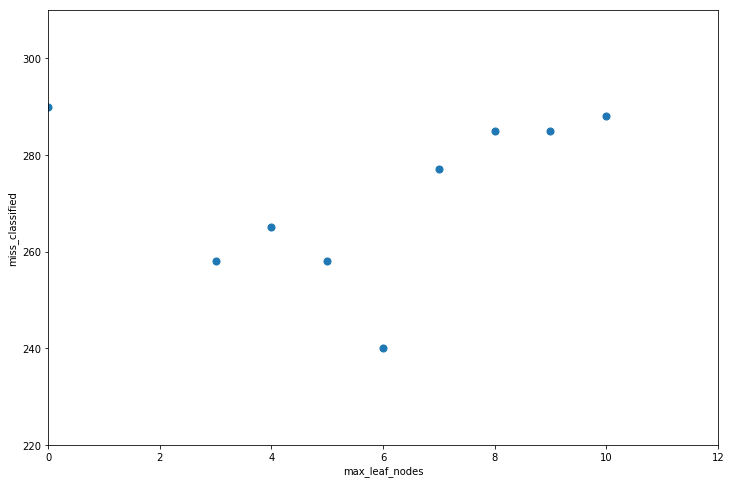

[239.99999999999997, 258.00000000000006, 258.00000000000006, 264.99999999999994, 277.0, 285.0, 285.0, 288.0, 290.0]
[6, 3, 5, 4, 7, 8, 9, 10, None]


In [137]:
# set of parameters to test
param_grid = {"criterion": ["entropy"],
              
              "max_leaf_nodes": [None,3,4,5,6,7,8,9,10],
              }

dt = DecisionTreeClassifier()
ts_gs = run_gridsearch(X, Y, dt, param_grid, cv=10)

In [138]:
# At max_leaf = 6 the acuracie is the highest 0.771 . 
# This is obtained by 10 fold cross validation.

In [139]:
# Fitting model
prune_decision_tree = DecisionTreeClassifier(max_leaf_nodes=6,criterion="entropy")

## Plotting the pruned tree and getting the accuracies of pruned treee

In [140]:
prune_decision_tree.fit(X_train, Y_train)
visualize_tree(prune_decision_tree, X.columns)

In [141]:
in_sample = pd.DataFrame(list(zip(prune_decision_tree.predict(X_train), Y_train)), columns=['predicted', 'actual'])
out_sample = pd.DataFrame(list(zip(prune_decision_tree.predict(X_test), Y_test)), columns=['predicted', 'actual'])

In [142]:
in_sample_survivor = in_sample[in_sample.actual == 1]
total_survivor = in_sample_survivor.count().actual
print("total_survivor == %.3f" %total_survivor)

in_sample_survivor_success = in_sample_survivor[in_sample_survivor.predicted == 1]
total_survivor_success = in_sample_survivor_success.count().actual
print("total_survivor_success == %.3f" %total_survivor_success)

in_sample_survivor_accuracy = total_survivor_success/ total_survivor
print("in_sample_survivor_accuracy == %.3f" %in_sample_survivor_accuracy )

total_survivor == 243.000
total_survivor_success == 130.000
in_sample_survivor_accuracy == 0.535


In [143]:
in_sample_fatalities = in_sample[in_sample.actual == 0]
total_fatalities = in_sample_fatalities.count().actual
print("total_fatalities == %.3f" %total_fatalities)

in_sample_fatalities_success = in_sample_fatalities[in_sample_fatalities.predicted == 0]
total_fatalities_success = in_sample_fatalities_success.count().actual
print("total_fatalities_success == %.3f" %total_fatalities_success)

in_sample_fatalities_accuracy = total_fatalities_success/ total_fatalities
print("in_sample_fatalities_accuracy == %.3f" %in_sample_fatalities_accuracy )

total_fatalities == 384.000
total_fatalities_success == 371.000
in_sample_fatalities_accuracy == 0.966


In [144]:
out_sample_survivors = out_sample[out_sample.actual == 1]
out_total_survivors = out_sample_survivors.count().actual
print("out-total_survivors == %.3f" %out_total_survivors)

out_sample_survivors_success = out_sample_survivors[out_sample_survivors.predicted == 1]
out_total_survivors_success = out_sample_survivors_success.count().predicted
print("out_total_survivors_success == %.3f" %out_total_survivors_success)

out_sample_survivors_accuracy = out_total_survivors_success/ out_total_survivors
print("out_sample_survivors_accuracy == %.3f" %out_sample_survivors_accuracy )

out-total_survivors == 184.000
out_total_survivors_success == 105.000
out_sample_survivors_accuracy == 0.571


In [145]:
out_sample_fatalities = out_sample[out_sample.actual == 0]
out_total_fatalities = out_sample_fatalities.count().actual
print("out-total_fatalities == %.3f" %out_total_fatalities)

out_sample_fatalities_success = out_sample_fatalities[out_sample_fatalities.predicted == 0]
out_total_fatalities_success = out_sample_fatalities_success.count().actual
print("out_total_fatalities_success == %.3f" %out_total_fatalities_success)

out_sample_fatalities_accuracy = out_total_fatalities_success/ out_total_fatalities
print("out_sample_fatalities_accuracy == %.3f" %out_sample_fatalities_accuracy )

out-total_fatalities == 235.000
out_total_fatalities_success == 225.000
out_sample_fatalities_accuracy == 0.957


In [146]:
# Comparison:

# Without Pruning
# out_sample_fatalities_accuracy == 0.819 , out_sample_survivors_accuracy == 0.648
# in_sample_fatalities_accuracy == 0.967 , in_sample_survivor_accuracy == 0.859


# After pruning 
# out_sample_fatalities_accuracy == 0.965 , out_sample_survivors_accuracy == 0.521
# in_sample_fatalities_accuracy == 0.973 , in_sample_survivor_accuracy == 0.603


#  After pruning in and out sample survivor accuracy has gone down but fatalities acuracy has gone up.

